Forked from the original tutorial proposed by Sayak Paul:
https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/segformer.ipynb#scrollTo=3isM4uiS66Zl
Some comments and advices were left in the notebook as they may help understanding the process.

# Anchor segmentation in map images with SegFormer


In this notebook, we load a pretrained (on ImageNet) segformer model and fine tune it with our own segmentation dataset.

# Imports

In [ ]:
!!pip install transformers -q

[]

In [ ]:
import os

import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import TFSegformerForSemanticSegmentation

import matplotlib.pyplot as plt

In [ ]:
# Tf version: 2.18.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


# Data path

In [ ]:
PROJECT_PATH = '/content/drive/MyDrive/Colab Notebooks/landmark_segmentation/'

IMG_PATH = PROJECT_PATH + 'datasets/segformer/images/'
MSK_PATH = PROJECT_PATH + 'datasets/segformer/targets/'

IMG_PATH_TEST = PROJECT_PATH + 'datasets/test_set/pign_z14/image/'
MSK_PATH_TEST = PROJECT_PATH + 'datasets/test_set/pign_z14/mask/'
PRED_PATH = PROJECT_PATH + 'datasets/test_set/pign_z14/pred_segformer/'

MODEL_PATH = PROJECT_PATH + 'models/'
MODEL_NAME = 'segf'
MODEL_WEIGHTS_PATH = MODEL_PATH + MODEL_NAME + ".weights.h5"
MODEL_BEST_WEIGHTS_PATH = MODEL_PATH + MODEL_NAME + "_best.weights.h5"

# Params

In [ ]:
BATCH_SIZE = 8
IMG_SIZE = (600, 1200)

# Prepare training dataset

## Partition

The partition list the names of our data files and split them in a train and validation set. It is a dictionnary

In [ ]:
def create_partition(folder_path, validation_split=0.2):
    im_names = os.listdir(folder_path)
    train_names, val_names = train_test_split(im_names, test_size=validation_split, random_state=42)
    partition = {'train': train_names, 'validation': val_names}
    return partition

In [ ]:
partition = create_partition(IMG_PATH, validation_split=0.1)
len_train = len(partition['train'])
len_val = len(partition['validation'])

In [ ]:
# Test
print(len(os.listdir(IMG_PATH)))
print(len_train, len_val)
print(partition['train'][0])

1172
1054 118
590_1.png


## Build tensor from image

In [ ]:
def load_image_as_tensor(img_path, color_mode='rgb'):
    img_pil = tf.keras.utils.load_img(img_path, color_mode=color_mode)
    img_array = tf.keras.utils.img_to_array(img_pil)
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8) # commenter si besoin d'un np array plutot qu'un tenseur
    return img_tensor

In [ ]:
def tensor_info(tensor):
    print("\nTensor Information:")
    tf.print("Shape:", tf.shape(tensor))
    tf.print("Data Type:", tensor.dtype)
    tensor_min = tf.reduce_min(tensor)
    tensor_max = tf.reduce_max(tensor)
    print("Tensor range: min =", tensor_min.numpy(), ", max =", tensor_max.numpy())
    print('tf.rank() -->', tf.rank(tensor))
    print('.ndim -->', tensor.ndim)

In [ ]:
# Test
tensor_test = load_image_as_tensor(IMG_PATH + partition['train'][0])
tensor_info(tensor_test)


Tensor Information:
Shape: [600 1200 3]
Data Type: tf.uint8
Tensor range: min = 0 , max = 255
tf.rank() --> tf.Tensor(3, shape=(), dtype=int32)
.ndim --> 3


## Tensor generator (image, mask)

In [ ]:
# Python generator that yield tuples (image_tensor, mask_tensor) using load_image_as_tensor
def img_msk_generator(img_folder, msk_folder, img_names):
    # encode and decode handles a byte vs str error
    try:
        img_folder = img_folder.decode()
    except (UnicodeDecodeError, AttributeError):
        pass

    try:
        msk_folder = msk_folder.decode()
    except (UnicodeDecodeError, AttributeError):
        pass

    # generator
    while True:
        for name in img_names:
            # handle byte vs str error
            try:
                name = name.decode()
            except (UnicodeDecodeError, AttributeError):
                pass
            # create tensor
            img_path = os.path.join(img_folder, name)
            msk_name = (name.split('.')[0] + '_mask.png')  # Assuming masks end with '_mask.png'
            msk_path = os.path.join(msk_folder, msk_name)

            img_tensor = load_image_as_tensor(img_path)
            msk_tensor = load_image_as_tensor(msk_path, color_mode='grayscale')

            yield (img_tensor, msk_tensor)


In [ ]:
# Test
#train_gen = img_msk_generator(IMG_PATH, MSK_PATH, partition['train'])
#print(train_gen)

## Tensorflow Datasets from generators

In [ ]:
train_ds = tf.data.Dataset.from_generator(
    img_msk_generator,
    args=(IMG_PATH, MSK_PATH, partition['train']),
    output_signature=(
    tf.TensorSpec(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), dtype=tf.uint8),
    tf.TensorSpec(shape=(IMG_SIZE[0], IMG_SIZE[1], 1), dtype=tf.uint8))
)

valid_ds = tf.data.Dataset.from_generator(
    img_msk_generator,
    args=(IMG_PATH, MSK_PATH, partition['validation']), # passed to the generator as numpy-array argument
    output_signature=(
    tf.TensorSpec(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), dtype=tf.uint8),
    tf.TensorSpec(shape=(IMG_SIZE[0], IMG_SIZE[1], 1), dtype=tf.uint8))
)


In [ ]:
test_ds = tf.data.Dataset.from_generator(
    img_msk_generator,
    args=(IMG_PATH_TEST, MSK_PATH_TEST, os.listdir(IMG_PATH_TEST)),
    output_signature=(
    tf.TensorSpec(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), dtype=tf.uint8),
    tf.TensorSpec(shape=(IMG_SIZE[0], IMG_SIZE[1], 1), dtype=tf.uint8))
)

In [ ]:
# Test
print(train_ds.element_spec)

(TensorSpec(shape=(600, 1200, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(600, 1200, 1), dtype=tf.uint8, name=None))


## Prepare the datasets for the model
* Normalize the images with the mean and standard deviation used during pre-training
SegFormer.
* Transpose the images to `"channels_first"` format to make
them compatible with the SegFormer model.

In [ ]:
mean = tf.constant([0.485, 0.456, 0.406]) # RGB values, come from the ImageNet dataset used for pretraining
std = tf.constant([0.229, 0.224, 0.225])

def normalize_image(input_image):
    input_image = tf.image.convert_image_dtype(input_image, tf.float32)
    input_image = (input_image - mean) / tf.maximum(std, tf.keras.backend.epsilon())
    return input_image

def normalize_mask(input_mask):
    color_map = {(255):1, # white
                 (0):0} # black
    # Create an output tensor initialized with zeros
    input_mask_shape = tf.shape(input_mask)
    input_mask_new = tf.zeros(input_mask_shape, dtype=tf.int32)
    # Assign unique values based on the color mapping
    for color, value in color_map.items():
        mask = tf.reduce_all(tf.equal(input_mask, tf.constant(color, dtype=tf.uint8)), axis=-1)
        mask = tf.expand_dims(mask, axis=-1) # adding a third dimension of size 1 (channel) to match with our input_mask
        input_mask_new = tf.where(mask, value, input_mask_new)
    return input_mask_new


image_spec = tf.TensorSpec(shape=[600, 1200, 3], dtype=tf.uint8)  # For images
mask_spec = tf.TensorSpec(shape=[600, 1200, 1], dtype=tf.uint8)  # For masks

@tf.function(input_signature=[image_spec, mask_spec])
def load_image(input_image, input_mask):
    input_image = normalize_image(input_image)
    input_mask = normalize_mask(input_mask)

    input_image = tf.transpose(input_image, (2, 0, 1)) # put channel before heigth and width, as expected by the model
    input_mask = tf.squeeze(input_mask, 2) # remove channel dim for masks (segformer model doesnt want it)

    return {"pixel_values": input_image, "labels": input_mask}


We now use the above utilities to prepare `tf.data.Dataset` objects including
`prefetch()` for performance.

In [ ]:
auto = tf.data.AUTOTUNE
batch_size = BATCH_SIZE

train_ds = (
    train_ds
    .cache()
    .shuffle(batch_size * 10)
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)

valid_ds = (
    valid_ds
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)

test_ds = (
    test_ds
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)


In [ ]:
# check the shapes of the input images and their segmentation maps
print(train_ds.element_spec)

{'pixel_values': TensorSpec(shape=(None, 3, 600, 1200), dtype=tf.float32, name=None), 'labels': TensorSpec(shape=(None, 600, 1200), dtype=tf.int32, name=None)}


# Display

In [ ]:
def display_img_from_tensor(tensor, title):
    plt.figure(figsize=(6, 6))
    plt.title(title)
    plt.imshow(tf.keras.utils.array_to_img(tensor), cmap='gray')
    plt.axis("off")
    plt.show()

In [ ]:
# Test
# img, msk = next(train_gen)
# display_img_from_tensor(img, "image")
# display_img_from_tensor(msk, "mask")

In [ ]:
# display images from a tensor list, need channel dim at the end (h, w, c)
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Logits", "Pred argmax"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap='gray')
        plt.axis("off")
    plt.show()
    plt.close()

In [ ]:
# Test
#for samples in valid_ds.take(2):
#    sample_image = samples["pixel_values"][0] # [0] means first element of the batch
#    sample_mask = samples["labels"][0]
#    sample_image = tf.transpose(sample_image, (1, 2, 0)) # put channels after height and width
#    sample_mask = tf.expand_dims(sample_mask, -1) # add a dimension of length 1 to mask so it has 3 dim (heigth, width, channel=1)
#    display([sample_image, sample_mask])

# Prepare model

## Load a pretrained SegFormer checkpoint

We use the **MiT-B0** segformer variant recommanded in the original article

In [ ]:
model_checkpoint = "nvidia/mit-b0"
#id2label = {0: "outer", 1: "inner", 2: "border"}
id2label = {0: "no anchor", 1: "anchor"} # new labels
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)

model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/14.6M [00:00<?, ?B/s]

Some layers from the model checkpoint at nvidia/mit-b0 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is telling us that we're throwing away some weights and newly initializing
some others. Don't panic! This is absolutely normal. Since we're using a custom dataset
which has a different set of semantic class labels than the pre-training dataset,
[`TFSegformerForSemanticSegmentation`](https://huggingface.co/docs/transformers/model_doc/segformer#transformers.TFSegformerForSemanticSegmentation)
is initializing a new decoder head.

We can now initialize an optimizer and compile the model with it.

## Compile the model

In [ ]:
optimizer = tf.keras.optimizers.Adam()
#optimizer = "adam"

model.compile(optimizer=optimizer)
#model.compile(optimizer=optimizer, run_eagerly=True)

In [ ]:
model.summary() # Display the model's architecture

Model: "tf_segformer_for_semantic_segmentation_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segformer (TFSegformerMain  multiple                  3319392   
 Layer)                                                          
                                                                 
 decode_head (TFSegformerDe  multiple                  395778    
 codeHead)                                                       
                                                                 
Total params: 3715170 (14.17 MB)
Trainable params: 3714658 (14.17 MB)
Non-trainable params: 512 (2.00 KB)
_________________________________________________________________


# Callbacks


## Display callback

In [ ]:
def show_predictions(dataset=None, num=1):
    # called every epoch, display image, mask, prediction and logits
    if dataset:
        for sample in dataset.take(num): # take batches. even we only use batches of size 1

            images, masks = sample["pixel_values"], sample["labels"]
            # dim images --> (batch=1, channel=3, heigth, width)
            # dim masks --> (batch=1, heigth, width)

            masks = tf.expand_dims(masks, 1) # add a dimension of length 1 to masks in second position, representing channels

            # Prediction
            pred_logits = model.predict(images).logits # dim = (batch=1, channel=2, heigth, width)

            pred_masks = tf.math.argmax(pred_logits, axis=1) # argmax before selecting channel
            # dim = (batch=1, heigth, width)

            pred_logits = pred_logits[:, 1, :, :] # Select channel 1 (anchor class) from the logits

            # Postprocess to display
            images = tf.transpose(images, (0, 2, 3, 1)) # move the channel dim at the end
            masks = tf.transpose(masks, (0, 2, 3, 1)) # move the channel dim at the end
            pred_masks = tf.expand_dims(pred_masks, -1) # add channel dim at the end
            pred_logits = tf.expand_dims(pred_logits, -1) # add channel dim at the end

            display([images[0], masks[0], pred_logits[0], pred_masks[0]])


class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, display_frequency=1, **kwargs):
        super().__init__(**kwargs)
        self.dataset = dataset
        self.display_frequency = display_frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.display_frequency == 0:
            print("\nSample Prediction after epoch {}\n".format(epoch + 1))
            show_predictions(self.dataset)

In [ ]:
# Test show_predictions
#show_predictions(test_ds, 3)

## Checkpoint callbacks
* allow to resume training from a checkpoint
* save best weigths during training

In [ ]:
CHECKPOINT_DIR = MODEL_PATH + "segf_checkpoints/segf"
# Create a checkpoint saving object (to resume training)
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)

In [ ]:
class CheckpointCallback(tf.keras.callbacks.Callback):  # Callback for delayed checkpoint saving
    def __init__(self, filepath, start_saving_epoch=20, **kwargs):
        super().__init__(**kwargs)
        self.filepath = filepath
        self.start_saving_epoch = start_saving_epoch
        self.best_val_loss = float('inf')  # Initialize best validation loss

    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get('val_loss')
        if epoch + 1 >= self.start_saving_epoch and current_val_loss < self.best_val_loss:
            self.best_val_loss = current_val_loss
            self.model.save_weights(self.filepath)
            print(f"Saving weights at epoch {epoch + 1} with val_loss: {current_val_loss}")

    def on_train_end(self, logs=None):
        save_path = checkpoint.save(CHECKPOINT_DIR)
        print(f"Saved checkpoint for step: {save_path}")

## Clear memory callback

In [ ]:
import gc

In [ ]:
class ClearMemory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()

# Train model

## Load checkpoint

In [ ]:
# load checkpoint if there is one
latest_checkpoint = tf.train.latest_checkpoint(MODEL_PATH + "segf_checkpoints/")
if latest_checkpoint:
    checkpoint.restore(latest_checkpoint)
    print(f"Restored from checkpoint: {latest_checkpoint}")

Restored from checkpoint: /content/drive/MyDrive/Colab Notebooks/landmark_segmentation//models/segf_checkpoints/segf-8


## Train

In [ ]:
import time

Epoch 69/78
131/131 [==============================] - ETA: 0s - loss: 0.0810

/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Saving weights at epoch 69 with val_loss: 0.20259489119052887
131/131 [==============================] - 215s 1s/step - loss: 0.0810 - val_loss: 0.2026
Epoch 70/78
131/131 [==============================] - ETA: 0s - loss: 0.0815
Sample Prediction after epoch 70

1/1 [==============================] - 4s 4s/step


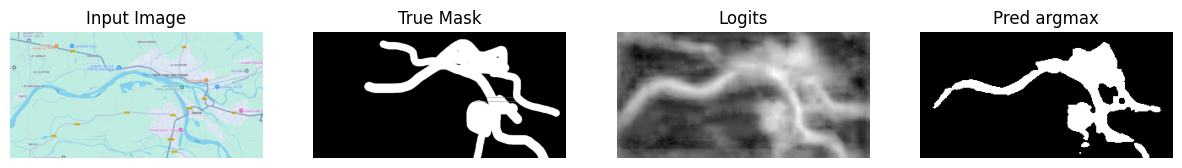

131/131 [==============================] - 160s 1s/step - loss: 0.0815 - val_loss: 0.2214
Epoch 71/78
131/131 [==============================] - 151s 1s/step - loss: 0.0871 - val_loss: 0.2146
Epoch 72/78
131/131 [==============================] - ETA: 0s - loss: 0.0839
Sample Prediction after epoch 72

1/1 [==============================] - 1s 1s/step


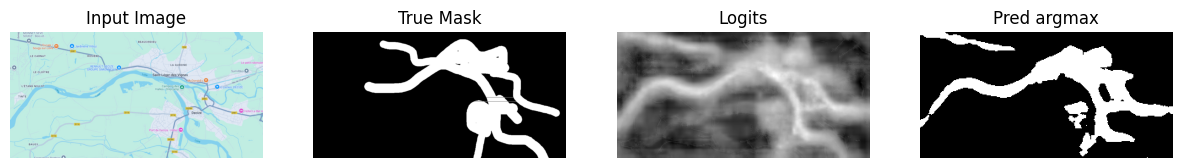

Saving weights at epoch 72 with val_loss: 0.20113448798656464
131/131 [==============================] - 153s 1s/step - loss: 0.0839 - val_loss: 0.2011
Epoch 73/78
131/131 [==============================] - 146s 1s/step - loss: 0.0819 - val_loss: 0.2141
Epoch 74/78
131/131 [==============================] - ETA: 0s - loss: 0.0831
Sample Prediction after epoch 74

1/1 [==============================] - 2s 2s/step


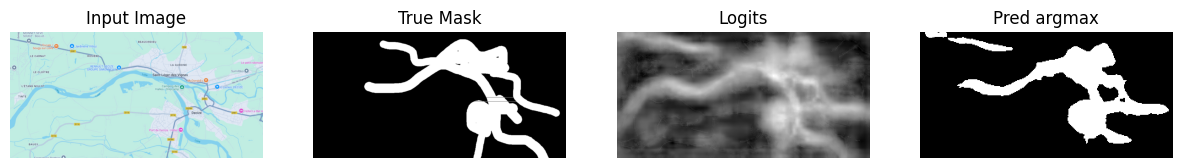

131/131 [==============================] - 145s 1s/step - loss: 0.0831 - val_loss: 0.2023
Epoch 75/78
131/131 [==============================] - 140s 1s/step - loss: 0.0793 - val_loss: 0.2020
Epoch 76/78
131/131 [==============================] - ETA: 0s - loss: 0.0872
Sample Prediction after epoch 76

1/1 [==============================] - 1s 1s/step


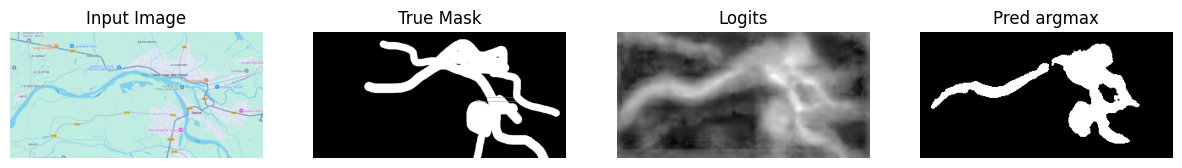

131/131 [==============================] - 143s 1s/step - loss: 0.0872 - val_loss: 0.2088
Epoch 77/78
131/131 [==============================] - 138s 1s/step - loss: 0.1231 - val_loss: 0.2501
Epoch 78/78
131/131 [==============================] - ETA: 0s - loss: 0.1217
Sample Prediction after epoch 78

1/1 [==============================] - 1s 1s/step


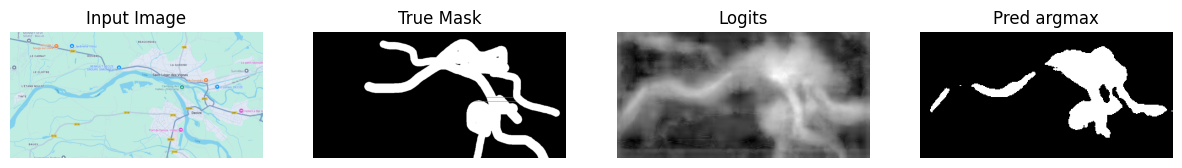

131/131 [==============================] - 144s 1s/step - loss: 0.1217 - val_loss: 0.2370
Saved checkpoint for step: /content/drive/MyDrive/Colab Notebooks/landmark_segmentation//models/segf_checkpoints/segf-8
Temps d'entraînement : 25.61 minutes


In [ ]:
start_time = time.time()

initial_epoch = 68
epochs_to_train = 10

new_history = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=initial_epoch + epochs_to_train,
    steps_per_epoch=len_train // batch_size,
    validation_data=valid_ds,
    validation_steps=len_val // batch_size,  # Specify the number of validation batches
    callbacks=[DisplayCallback(valid_ds, display_frequency=2),
               CheckpointCallback(MODEL_BEST_WEIGHTS_PATH, start_saving_epoch=10),
               ClearMemory()
               ],
    initial_epoch=initial_epoch
)

end_time = time.time()
training_time = end_time - start_time
print(f"Temps d'entraînement : {training_time / 60:.2f} minutes")

## Save model

In [ ]:
#model.save_weights(MODEL_WEIGHTS_PATH)

## Save history

In [ ]:
import json
HISTORY_PATH = MODEL_PATH + "segf_checkpoints/segf_history.json"

In [ ]:
# if history json doesnt exist create it, else update
if not os.path.exists(HISTORY_PATH):
    with open(HISTORY_PATH, 'w') as f:
        json.dump(new_history.history, f)
    f.close()

else:
    with open(HISTORY_PATH, 'r') as f:
        loaded_history = json.load(f)
    f.close()

    for key in new_history.history:
        loaded_history[key].extend(new_history.history[key])

    with open(HISTORY_PATH, 'w') as f:
        json.dump(loaded_history, f)
    f.close()

# Curves

In [ ]:
# open history
with open(HISTORY_PATH, 'r') as f:
    new_history = json.load(f)

In [ ]:
# print loss and val_loss values for each epoch
for i in range(len(new_history['loss'])):
    print(f"Epoch {i+1}: loss = {new_history['loss'][i]}, val_loss = {new_history['val_loss'][i]}")

Epoch 1: loss = 0.4366835951805115, val_loss = 0.36377206444740295
Epoch 2: loss = 0.3457569181919098, val_loss = 0.33666351437568665
Epoch 3: loss = 0.34042954444885254, val_loss = 0.32107803225517273
Epoch 4: loss = 0.329796701669693, val_loss = 0.3051070272922516
Epoch 5: loss = 0.3156838119029999, val_loss = 0.29873791337013245
Epoch 6: loss = 0.3141340911388397, val_loss = 0.2871007025241852
Epoch 7: loss = 0.30394411087036133, val_loss = 0.27690988779067993
Epoch 8: loss = 0.29457247257232666, val_loss = 0.3078337609767914
Epoch 9: loss = 0.28820616006851196, val_loss = 0.2932407855987549
Epoch 10: loss = 0.2879766523838043, val_loss = 0.2693777084350586
Epoch 11: loss = 0.27572575211524963, val_loss = 0.26043635606765747
Epoch 12: loss = 0.2731936573982239, val_loss = 0.24599184095859528
Epoch 13: loss = 0.26420700550079346, val_loss = 0.271392285823822
Epoch 14: loss = 0.270409494638443, val_loss = 0.2697661519050598
Epoch 15: loss = 0.2613779902458191, val_loss = 0.26945117115

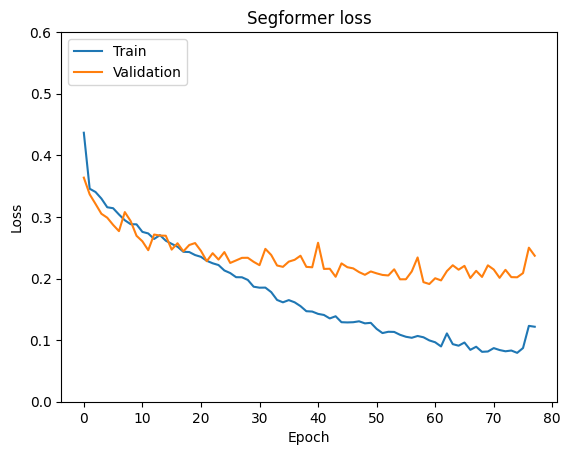

In [ ]:
# plot loss and val loss from history
plt.plot(new_history.history['loss'])
plt.plot(new_history.history['val_loss'])
plt.title('Segformer loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(0, 0.6)
plt.show()


# Evaluation

## Load model from checkpoint (loading only weights implies poor results)

In [ ]:
# Load model
model_checkpoint = "nvidia/mit-b0"
#id2label = {0: "outer", 1: "inner", 2: "border"}
id2label = {0: "no anchor", 1: "anchor"} # new labels
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)

new_model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,  # Use the same model_checkpoint
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)


Some layers from the model checkpoint at nvidia/mit-b0 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = tf.keras.optimizers.Adam()

In [ ]:
# Create a checkpoint saving object (to resume training)
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=new_model)

In [ ]:
checkpoint.restore(MODEL_PATH + "segf_checkpoints/segf-5")
print(f"Restored from checkpoint")

Restored from checkpoint


## Predict on evaluation dataset

In [ ]:
def make_pred(model, img_path):
  ### Prepare input
  img_tensor = load_image_as_tensor(img_path, color_mode='rgb')
  img_tensor_normalised = normalize_image(img_tensor)
  # put channel before heigth and width, as expected by the model
  input_image = tf.transpose(img_tensor_normalised, (2, 0, 1))
  # add an outer batch axis so shape is: [1(batch) 3(channels) h w]. It is needed by segformer model
  input_images = tf.expand_dims(input_image, axis=0)

  ### Predict ouputs
  pred_output = model.predict(input_images)
  return pred_output

In [ ]:
def pred_to_softmax(pred_output):
  pred_logits = pred_output.logits
  pred_softmax = tf.nn.softmax(pred_logits, axis=1)
  # Select the layer "prob to be anchors (in white)"
  pred_softmax = pred_softmax[:, 1, :, :]
  # take first of the batch
  pred_softmax = pred_softmax[0]
  pred_softmax = tf.expand_dims(pred_softmax, -1) # add a channel dim at the end (required for img)
  return pred_softmax

In [ ]:
def pred_to_argmax(pred_output):
  # retrieve the numpy numbers from prediction
  pred_logits = pred_output.logits
  pred_argmax = tf.math.argmax(pred_logits, axis=1)[0] # argmax and then select the first of the batch
  pred_argmax = tf.expand_dims(pred_argmax, -1) # add a channel dim at the end (required for img)
  return pred_argmax

1/1 [==============================] - 0s 180ms/step


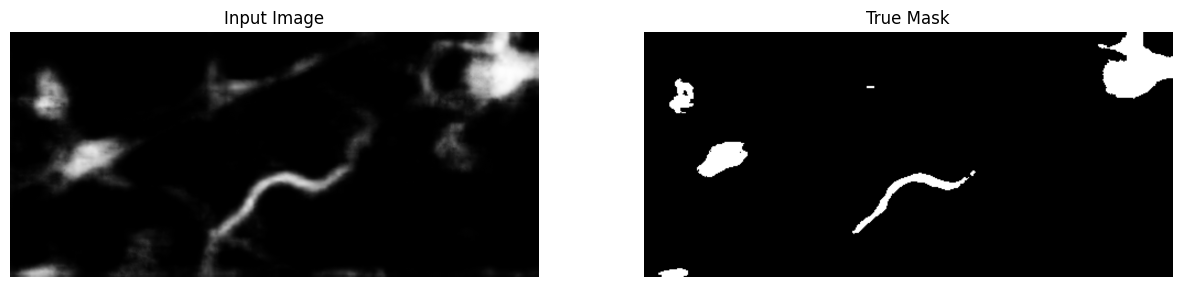

1/1 [==============================] - 0s 187ms/step


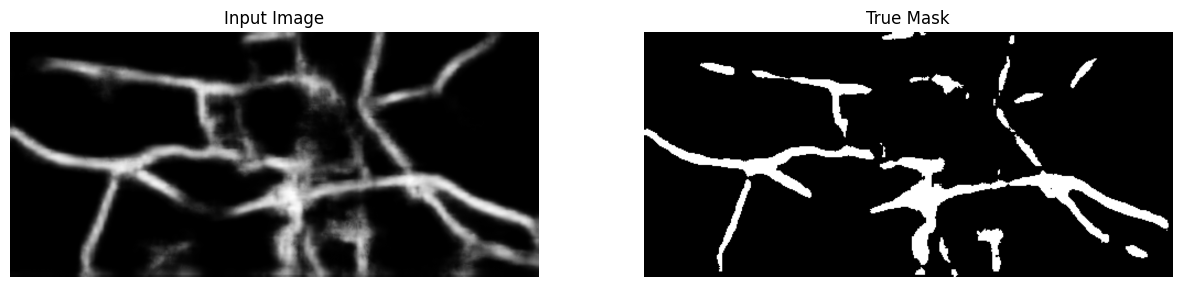

1/1 [==============================] - 0s 177ms/step


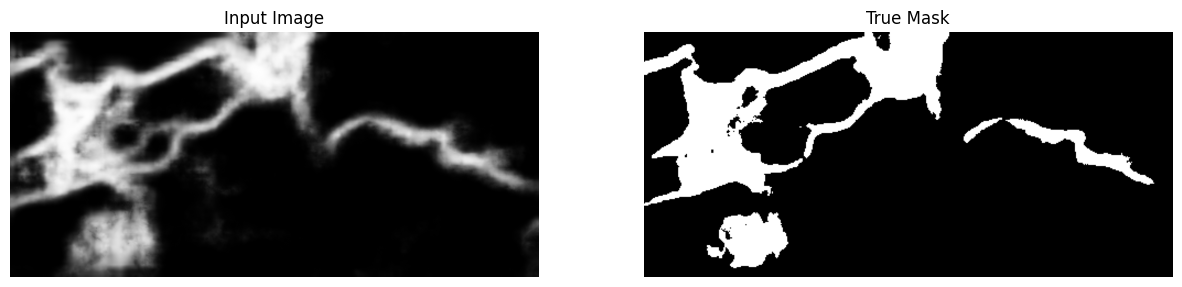

1/1 [==============================] - 0s 179ms/step


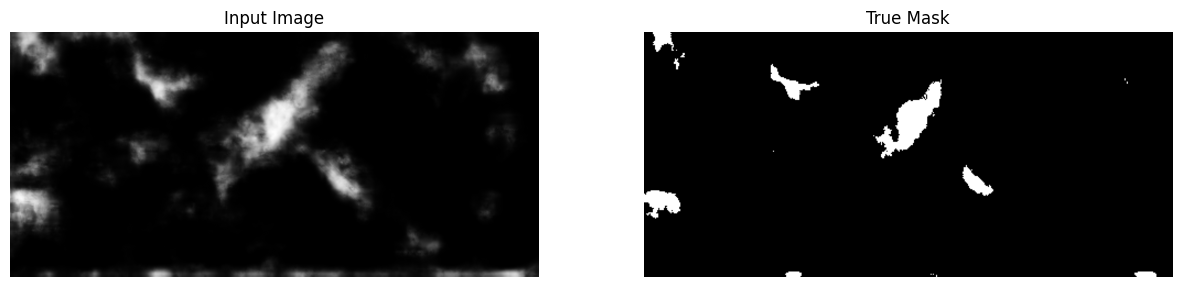

1/1 [==============================] - 0s 178ms/step


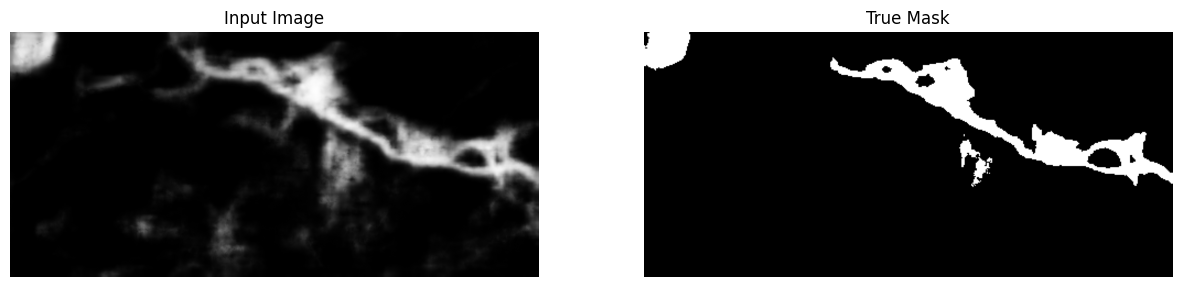

1/1 [==============================] - 0s 184ms/step


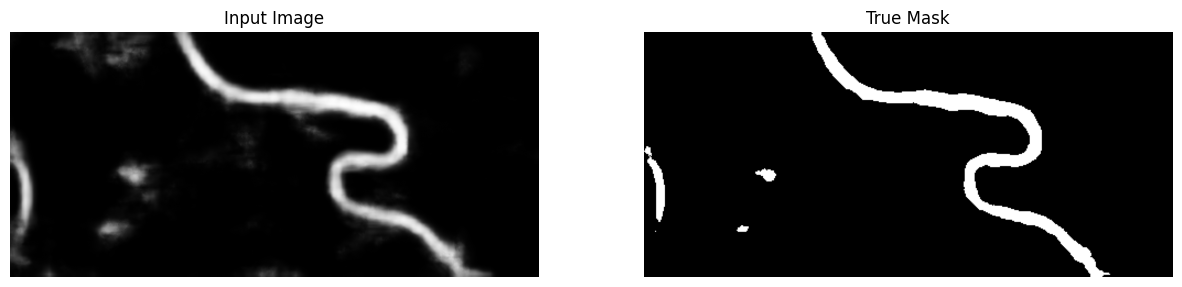

1/1 [==============================] - 0s 177ms/step


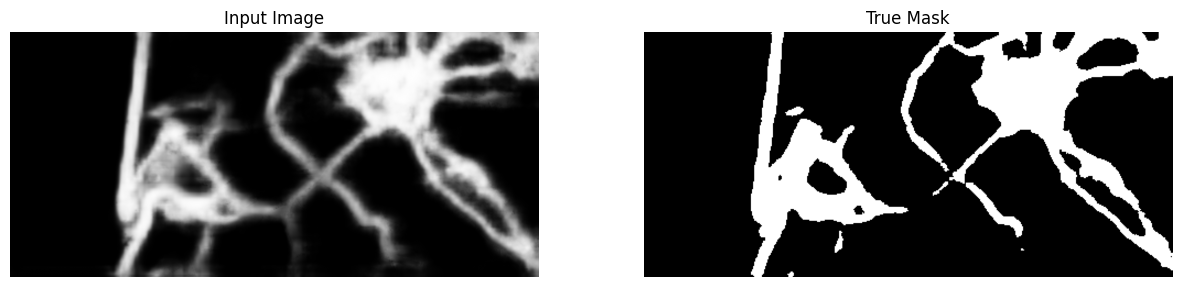

1/1 [==============================] - 0s 177ms/step


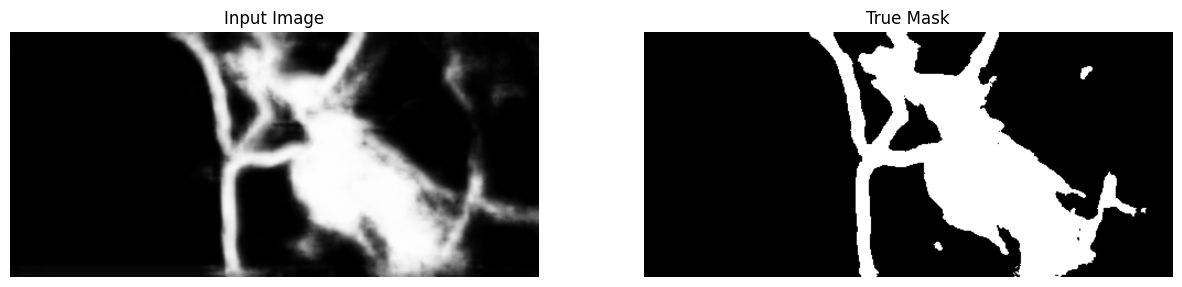

1/1 [==============================] - 0s 187ms/step


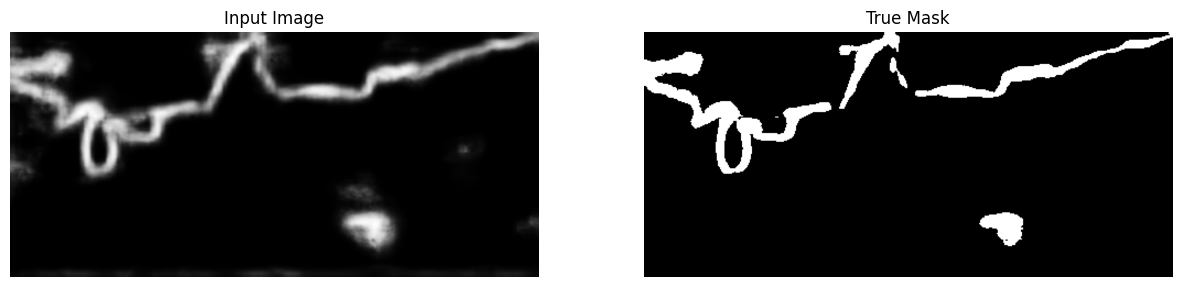

1/1 [==============================] - 0s 177ms/step


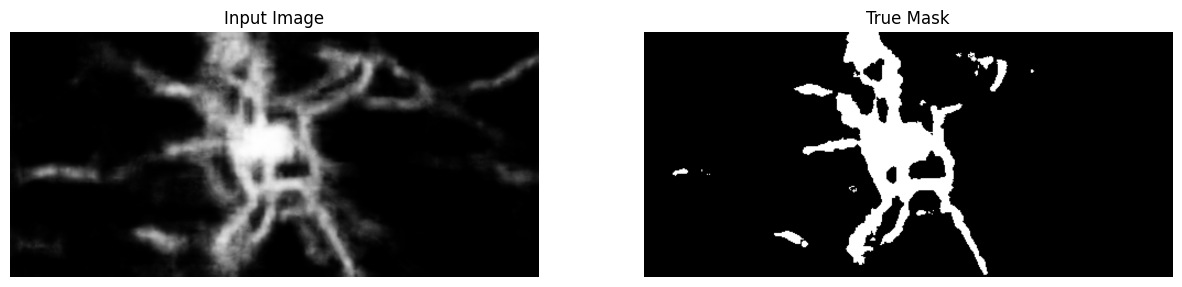

1/1 [==============================] - 0s 178ms/step


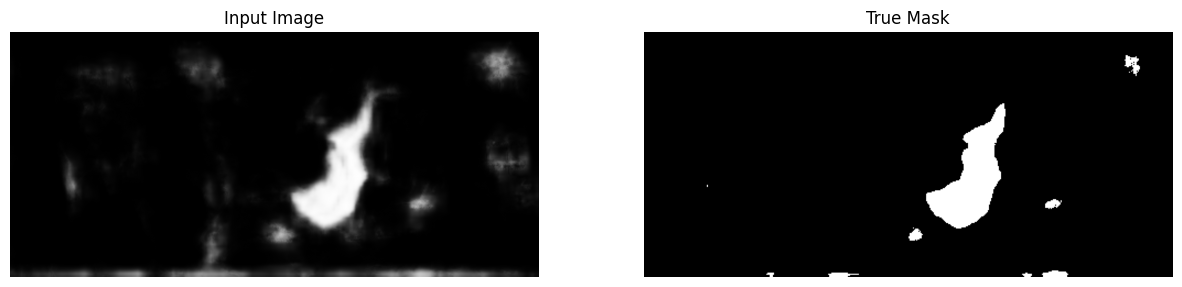

1/1 [==============================] - 0s 187ms/step


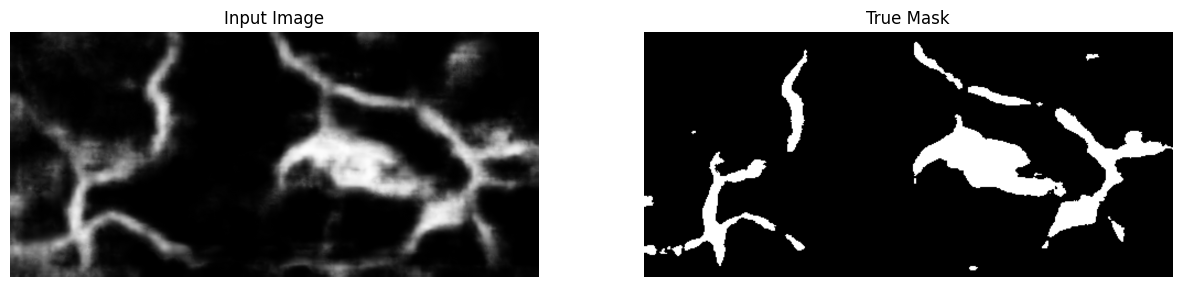

1/1 [==============================] - 0s 178ms/step


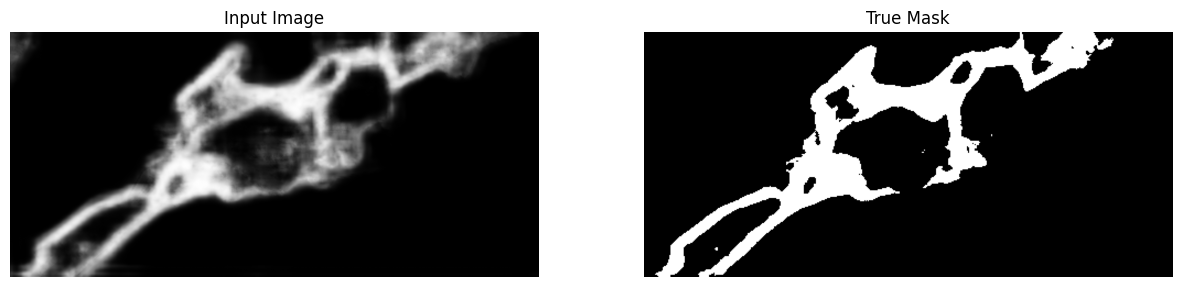

1/1 [==============================] - 0s 178ms/step


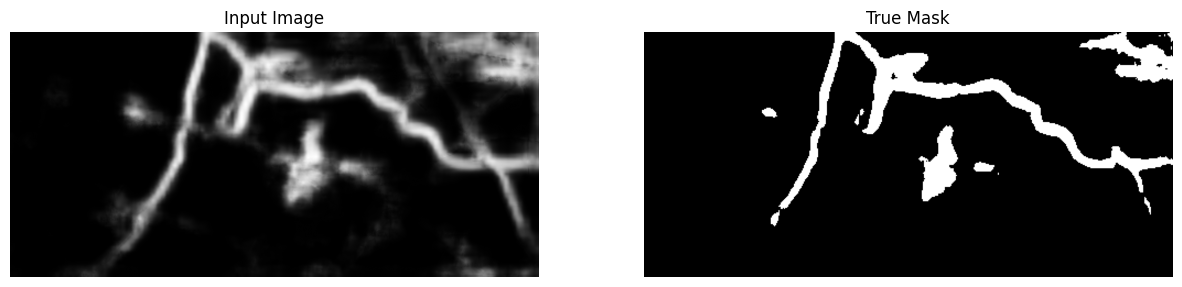

1/1 [==============================] - 0s 179ms/step


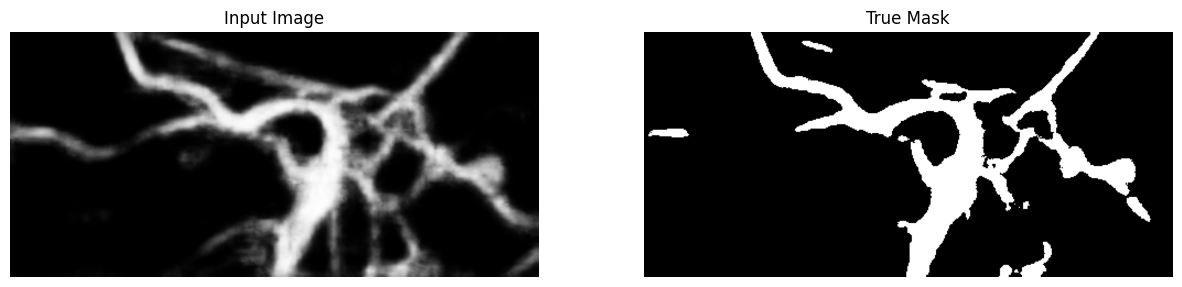

1/1 [==============================] - 0s 179ms/step


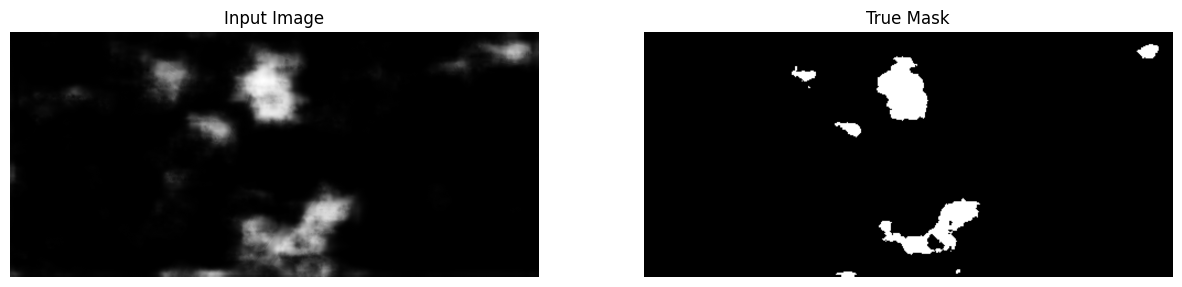

1/1 [==============================] - 0s 177ms/step


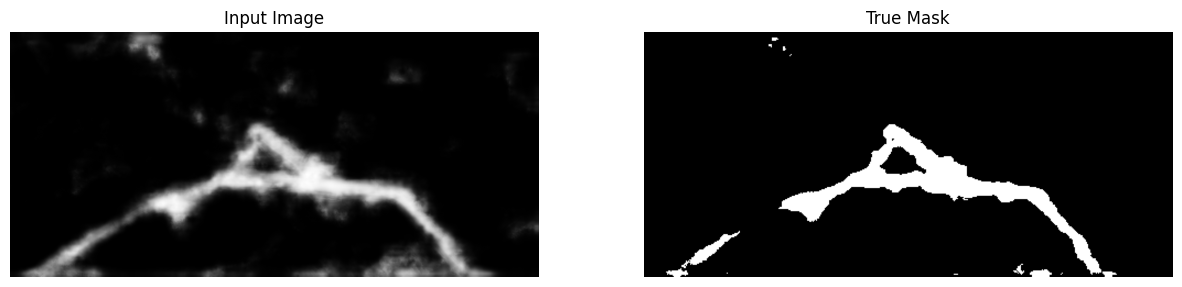

1/1 [==============================] - 0s 178ms/step


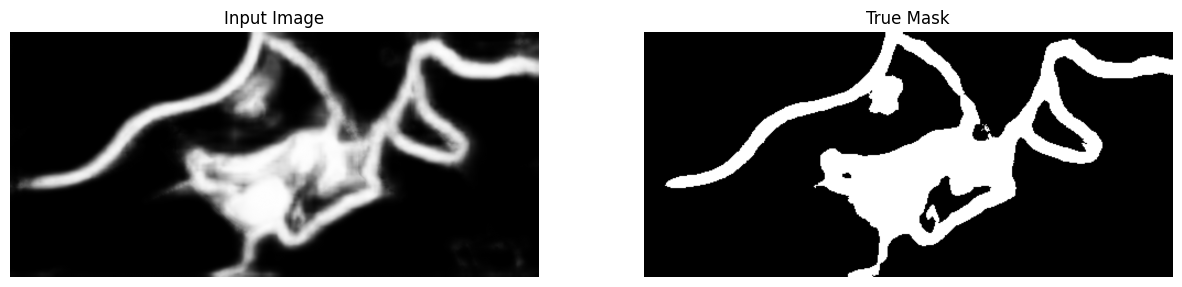

1/1 [==============================] - 0s 177ms/step


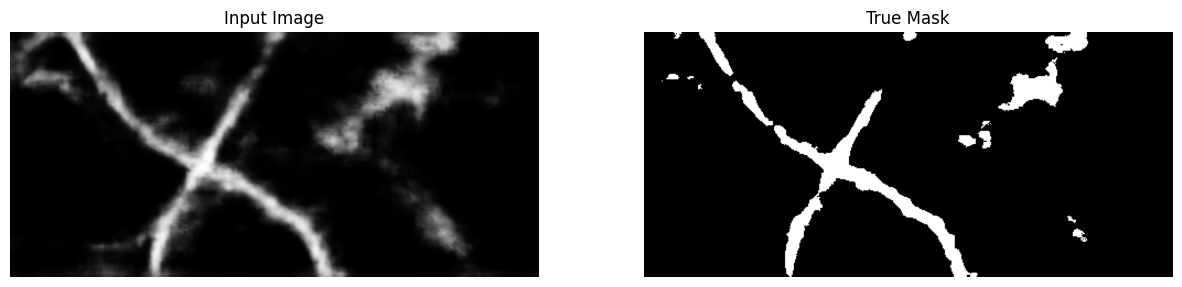

1/1 [==============================] - 0s 177ms/step


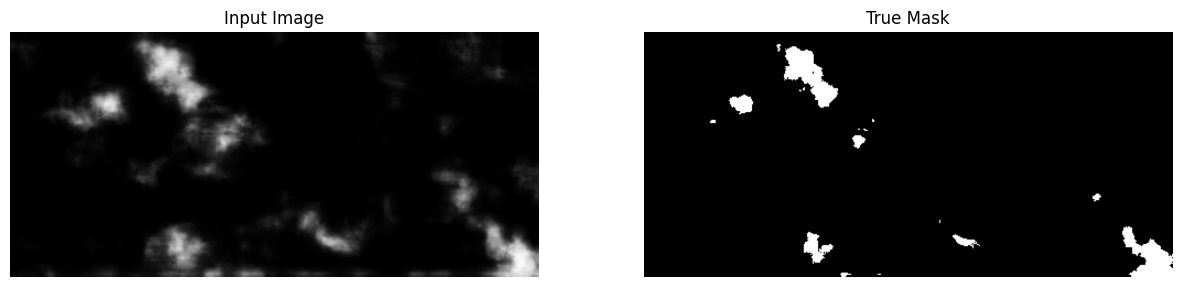

In [ ]:
# Pour chaque image, faire une prediction et sauvegarder le resultat dans le dossier pred
EVAL_PATH = PROJECT_PATH + 'eval/base_images/'
PRED_FOLDER = PROJECT_PATH + 'eval/pred_segformer/'

im_names = os.listdir(EVAL_PATH)

for name in im_names:
  im_path = EVAL_PATH + name

  pred = make_pred(new_model, im_path)

  softmax = pred_to_softmax(pred)
  argmax = pred_to_argmax(pred)

  softmax = tf.image.resize(softmax, (890, 1920), method='bilinear')
  argmax = tf.image.resize(argmax, (890, 1920), method='nearest')

  display([softmax, argmax])

  # save softmax

  softmax_path = PRED_FOLDER + "softmax/" + name[:-4] + "_segf_softmax.png"
  tf.keras.utils.save_img(softmax_path, softmax, data_format="channels_last", file_format=None, scale=True)

  # save argmax as pred

  argmax_path = PRED_FOLDER + "pred/" + name[:-4] + "_segf_argmax.png"
  tf.keras.utils.save_img(argmax_path, argmax, data_format="channels_last", file_format=None, scale=True)